###At what point in high school do students give up on math? Identifying knowledge gaps in high school and college math education using Stack Exchange's Math forum

#### Additional Questions:
    1. What are the most popular subjects over time? (Upvotes, Favorites and Views)
    2. What are the most hotly debated subjects over time? (Comment Count, Longevity)
    3. What are the most fundamental subjects students are asking about over time? (Asked multiple times, answered quickly and by only a few commenters)
    4. What are the demographics of the posters and commenters? (Education level, age and location)
    5. Who are the most active math people? How quickly do they reply? Who has way too much free time?
    6. Can I determine sex from username?

In [220]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from datetime import datetime
from sklearn import feature_extraction
import mpld3
from xml.etree import ElementTree as ET

from HTMLParser import HTMLParser

In [35]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [36]:
etree = ET.parse('Data/Math/math.stackexchange.com/Posts.xml')
root = etree.getroot()
i = 0
postdicts = []
for x in root.iter():
    postdicts.append(x.attrib)
postdata = pd.DataFrame(postdicts).ix[1:]

In [37]:
for index, row in postdata.iterrows():
    row['Body'] = strip_tags(row['Body'])

In [221]:
etree = ET.parse('Data/Math/math.stackexchange.com/Users.xml')
root = etree.getroot()
i = 0
userdicts = []
for x in root.iter():
    userdicts.append(x.attrib)
userdata = pd.DataFrame(userdicts).ix[1:]

In [374]:
userdata.replace(to_replace=['Bangalore, India','London, United Kingdom','New York, United States','San Francisco, CA','Mumbai, India','Paris, France','Sydney, Australia','Toronto, Canada','Moscow, Russia','Chennai, India','Los Angeles, CA','Berlin, Germany','Montreal, Canada','Melbourne, Australia','Hyderabad, India','Pune, India','Beijing, China','Vancouver, Canada','Stockholm, Sweden','Kolkata, India','New Delhi, India','UK','London'], 
                 value=['India','United Kingdom','New York, NY','California','India','France','Australia','Canada','Russia','India','California','Germany','Canada','Australia','India','India','China','Canada','Sweden','India','India','United Kingdom','United Kingdom'],inplace=True)

In [375]:
userdata.replace(to_replace=['California','New York, NY','Seattle, WA','Boston, MA','Chicago, IL','Austin, TX','Atlanta, GA','Pittsburgh, PA','Portland, OR','USA','San Diego, CA','Berkeley, CA'],value='United States',inplace=True)

In [376]:
def counter(x):
    x['Counter'] = x.Location.count()
    return x
counts = userdata.groupby("Location").apply(counter)
counts2 = counts[['Location','Counter']]
counts3 = counts2.drop_duplicates(cols='Location',take_last = True)
counts3.sort(columns='Counter',ascending=False,inplace=True)
counts4 = counts3[['Location','Counter']]
# userdata2.sort(columns='',ascending=False,inplace=True)

In [377]:
counts4.head(30)

,Location,Counter
171513,United States,3945
171322,India,2706
171622,United Kingdom,1482
171489,Germany,902
171132,Canada,877
171559,Australia,623
170315,France,576
171718,Russia,462
167586,Sweden,382
171098,Netherlands,325


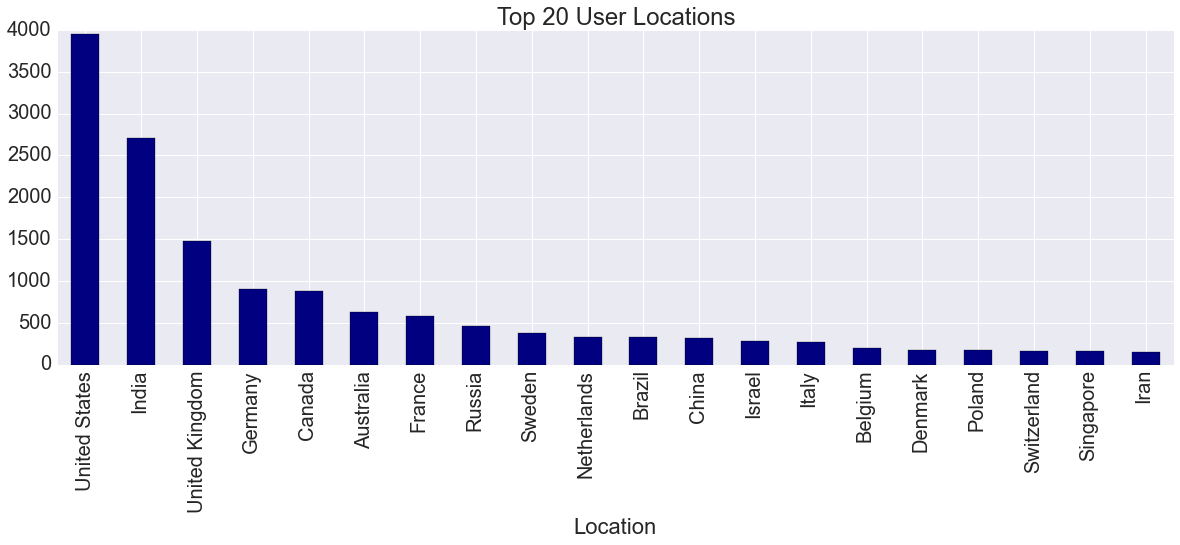

In [454]:
# Who are the users of the Math Forum?
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(font_scale=2)
sns.set_context(rc={"figure.figsize": (20, 6)})   
sns.set_palette("deep", desat=.8)
ax = counts4[0:20].plot(x='Location', y='Counter',kind='bar',colormap='jet',title='Top 20 User Locations',legend=False)

In [39]:
postdata = pd.merge(postdata, userdata, left_on='OwnerUserId', right_on='Id', how='left')

In [40]:
etree = ET.parse('Data/Math/math.stackexchange.com/Comments.xml')
root = etree.getroot()
i = 0
commentdicts = []
for x in root.iter():
    commentdicts.append(x.attrib)
commentdata = pd.DataFrame(commentdicts).ix[1:]

In [41]:
for index, row in commentdata.iterrows():
    row['Text'] = strip_tags(row['Text'])

In [42]:
commentdata = pd.merge(commentdata, userdata, left_on='UserId', right_on='Id', how='left')

In [43]:
commentdata.columns

Index([u'CreationDate_x', u'Id_x', u'PostId', u'Score', u'Text', u'UserDisplayName', u'UserId', u'AboutMe', u'AccountId', u'Age', u'CreationDate_y', u'DisplayName', u'DownVotes', u'Id_y', u'LastAccessDate', u'Location', u'ProfileImageUrl', u'Reputation', u'UpVotes', u'Views', u'WebsiteUrl'], dtype='object')

In [223]:
postdata.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'Body', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate', u'CreationDate_x', u'FavoriteCount', u'Id_x', u'LastActivityDate', u'LastEditDate', u'LastEditorDisplayName', u'LastEditorUserId', u'OwnerDisplayName', u'OwnerUserId', u'ParentId', u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'AboutMe', u'AccountId', u'Age', u'CreationDate_y', u'DisplayName', u'DownVotes', u'Id_y', u'LastAccessDate', u'Location', u'ProfileImageUrl', u'Reputation', u'UpVotes', u'Views', u'WebsiteUrl', u'Longevity', u'LongevitySeconds', u'BodyLength', u'HighSchoolSubject'], dtype='object')

In [52]:
type(postdata.ViewCount[0])
print postdata.FavoriteCount[0]

26.0


In [45]:
postdata.CreationDate_x = pd.to_datetime(postdata.CreationDate_x)
postdata.LastActivityDate = pd.to_datetime(postdata.LastActivityDate)

In [46]:
postdata['Longevity'] = postdata.LastActivityDate - postdata.CreationDate_x

In [47]:
LongevitySeconds = []
for row in postdata.Longevity:
    LongevitySeconds.append(row.total_seconds())
postdata['LongevitySeconds'] = LongevitySeconds
print postdata['LongevitySeconds'][0:4]

0    1.445760e+08
1    1.400873e+08
2    1.373870e+08
3    0.000000e+00
Name: LongevitySeconds, dtype: float64


In [48]:
print type(postdata.Longevity[0])
print postdata.Longevity[0]

<class 'pandas.tslib.Timedelta'>
1673 days 08:00:45.010000


In [49]:
test = postdata.Longevity[0].total_seconds()
print test
# postdata.LongevitySeconds = postdata.Longevity.total_seconds()
# print postdata.LongevitySeconds[0:10]

144576045.01


In [50]:
# Pull out tags
postdata.Tags = postdata.Tags.str.replace('\\<', '')
postdata.Tags = postdata.Tags.str.replace('\\>', ',')
postdata.Tags[0:10]

0                            set-theory,intuition,faq,
1                          calculus,limits,definition,
2             soft-question,big-list,online-resources,
3                                                  NaN
4                    number-theory,irrational-numbers,
5                         soft-question,math-software,
6                                                  NaN
7    linear-algebra,combinatorics,generating-functi...
8                                                  NaN
9               algebra-precalculus,decimal-expansion,
Name: Tags, dtype: object

In [51]:
removenans = postdata.Tags
removenans = removenans.fillna('')
postdata.Tags = removenans
postdata.Tags = postdata.Tags.str.strip(',')

In [52]:
postdata['BodyLength'] = postdata['Body'].str.len()
print postdata['BodyLength'][0:10]

0     269
1      71
2      72
3     191
4     196
5     117
6     285
7     392
8    1490
9     122
Name: BodyLength, dtype: int64


In [124]:
# Develop training set from subjects I am sure are 
# high-school or not high-school level
highschooltags = ['geometry','algebra','precalculus','algebra-precalculus','arithmetic','logarithms','exponentiation','fractions','decimal-expansion']
defnothighschooltags = ['calculus','differential-equations','real-analysis','linear-algebra','general-topology','complex-analysis','ring-theory','complex-numbers','pde','stochastic-processes','fourier-analysis','probability-theory','abstract-algebra','commutative-algebra','probability']
highschoolsubject = []
i = 0
for row in postdata.Tags:
    if any(subject not in highschooltags for subject in row.split(',')):
        if any(subject in defnothighschooltags for subject in row.split(',')):
            highschoolsubject.append(0.0)
        else:
            highschoolsubject.append(0.5)
    elif any(subject not in defnothighschooltags for subject in row.split(',')):
        highschoolsubject.append(1.0)
    else:
        highschoolsubject.append(1)
postdata['HighSchoolSubject'] = highschoolsubject

In [125]:
postdata[['Tags','HighSchoolSubject']][0:9]

,Tags,HighSchoolSubject
0,"set-theory,intuition,faq",0.5
1,"calculus,limits,definition",0.0
2,"soft-question,big-list,online-resources",0.5
3,,0.5
4,"number-theory,irrational-numbers",0.5
5,"soft-question,math-software",0.5
6,,0.5
7,"linear-algebra,combinatorics,generating-functi...",0.0
8,,0.5


#### What are the most popular subjects over time? (Frequency, Upvotes, Favorites and Views)

In [126]:
postdata.AnswerCount = postdata.AnswerCount.fillna(0)
postdata.Longevity = postdata.Longevity.fillna(0)
postdata.FavoriteCount = postdata.FavoriteCount.fillna(0)
postdata.CommentCount = postdata.CommentCount.fillna(0)
postdata.ViewCount = postdata.ViewCount.fillna(0)
postdata.BodyLength = postdata.BodyLength.fillna(0)

In [127]:
import pickle
with open('StackOverflowPostData.pkl', 'w') as picklefile:
    pickle.dump(postdata, picklefile)
with open('StackOverflowTopicFreqs.pkl', 'w') as picklefile:
    pickle.dump(uniquetags, picklefile)

###Import pickled xml to dataframe

In [1]:
import pickle
with open("StackOverflowPostData.pkl", 'r') as picklefile: 
    postdata = pickle.load(picklefile)
with open("StackOverflowTopicFreqs.pkl", 'r') as picklefile: 
    uniquetags = pickle.load(picklefile)

In [8]:
postdata['AnswerCount'] = postdata['AnswerCount'].astype(float)

In [9]:
for col in ['AnswerCount', 'FavoriteCount', 'CommentCount', 'ViewCount']:
    postdata[col] = postdata[col].astype(float)

In [136]:
# %%timeit

# `results` is a dictionary where the keys are tags
# and the values are dictionaries where the keys are
# the things we want to aggregate.
things = ['LongevitySeconds', 'AnswerCount', 'FavoriteCount',
          'CommentCount', 'ViewCount', 'BodyLength']
results = {}
running_sum = 0
running_count = 0
for index in xrange(len(postdata)):
    tags = postdata.iloc[index]['Tags'].split(',')
    for tag in tags:
        for thing in things:
            value = postdata.iloc[index][thing]
            running_sum, running_count = results.setdefault(tag, {}).get(thing, (0, 0))
            results[tag][thing] = [running_sum + value, running_count + 1]

In [137]:
results['algebra-precalculus']['AnswerCount']

[27420.0, 13160]

In [138]:
tagstats = pd.DataFrame.from_dict(results)
tagstats2 = tagstats.transpose()

In [139]:
tagstats2.head()

,AnswerCount,BodyLength,CommentCount,FavoriteCount,LongevitySeconds,ViewCount
,"[0.0, 596320]","[422587540, 596320]","[896301.0, 596320]","[0.0, 596320]","[360427361860.0, 596320]","[0.0, 596320]"
2-categories,"[6.0, 9]","[6131, 9]","[8.0, 9]","[2.0, 9]","[6516330.828, 9]","[370.0, 9]"
2-groups,"[6.0, 7]","[4762, 7]","[29.0, 7]","[17.0, 7]","[183307981.115, 7]","[772.0, 7]"
3d,"[966.0, 814]","[617443, 814]","[1583.0, 814]","[254.0, 814]","[3962347268.74, 814]","[413932.0, 814]"
abelian-categories,"[197.0, 193]","[150127, 193]","[443.0, 193]","[221.0, 193]","[777818719.881, 193]","[34933.0, 193]"


In [142]:
type(tagstats2.AnswerCount[0])

list

In [143]:
Frequency = []
for row in tagstats2.AnswerCount:
    Frequency.append(row.pop())
print Frequency[0:10]

[596320, 9, 7, 814, 193, 957, 51, 73, 576, 22687]


In [182]:
for index in xrange(len(tagstats2)):
    for col in range(1,6):
        tagstats2.iloc[index][col].pop()

In [183]:
tagstats2.head()

,AnswerCount,BodyLength,CommentCount,FavoriteCount,LongevitySeconds,ViewCount
,[0.0],[422587540],[896301.0],[0.0],[360427361860.0],[0.0]
2-categories,[6.0],[6131],[8.0],[2.0],[6516330.828],[370.0]
2-groups,[6.0],[4762],[29.0],[17.0],[183307981.115],[772.0]
3d,[966.0],[617443],[1583.0],[254.0],[3962347268.74],[413932.0]
abelian-categories,[197.0],[150127],[443.0],[221.0],[777818719.881],[34933.0]


In [193]:
for index in xrange(len(tagstats2)):
    for col in range(0,6):
        tagstats2.iloc[index][col] = tagstats2.iloc[index][col][0]

In [196]:
tagstats2['Frequency'] = Frequency
tagstats2.head()

,AnswerCount,BodyLength,CommentCount,FavoriteCount,LongevitySeconds,ViewCount,Frequency
,0,422587540,896301,0,3.604274e+11,0,596320
2-categories,6,6131,8,2,6516331,370,9
2-groups,6,4762,29,17,1.83308e+08,772,7
3d,966,617443,1583,254,3.962347e+09,413932,814
abelian-categories,197,150127,443,221,7.778187e+08,34933,193


In [204]:
tagstats2.LongevitySeconds = tagstats2.LongevitySeconds/3600.0

In [211]:
tagstats2.columns = ['AnswerCount','BodyLength','CommentCount','FavoriteCount','LongevityHours','ViewCount','Frequency']

In [212]:
tagstats2.sort(columns='LongevityHours',ascending=False,inplace=True)

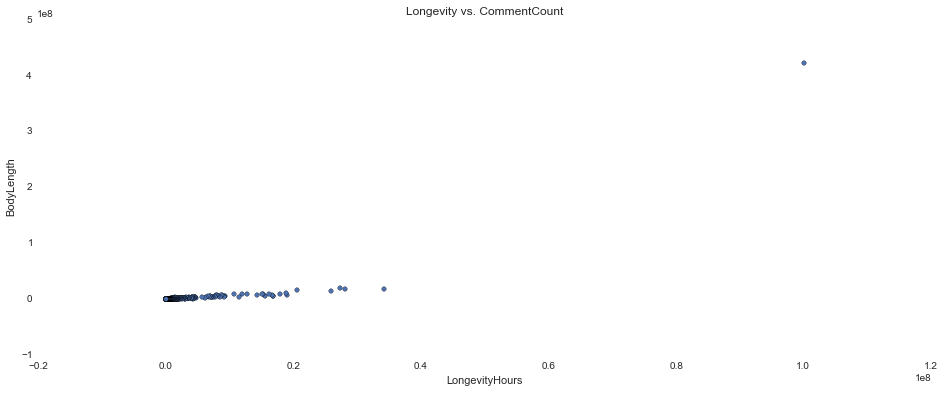

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab as pl
import seaborn as sns

# dataforplotting = tagstats2[['CommentCount','LongevityHours']]
tagstats2.plot(kind='scatter',x='LongevityHours',y='BodyLength',title='Longevity vs. CommentCount',figsize=(16, 6))
# plt.xlim(0, 40000000)
# plt.ylim(0,200000)
plt.show()

In [467]:
# What are the most popular topics?
toptopics = tagstats2[['Frequency','CommentCount','ViewCount','FavoriteCount']]
toptopics.CommentCount = toptopics.CommentCount / toptopics.Frequency
toptopics.ViewCount = toptopics.ViewCount / toptopics.Frequency
toptopics.FavoriteCount = toptopics.FavoriteCount / toptopics.Frequency

toptopics.sort(columns='ViewCount',ascending=False,inplace=True)
toptopics[1:11]
# counts3 = counts2.drop_duplicates(cols='Location',take_last = True)
# counts4 = counts3[['Location','Counter']]

,Frequency,CommentCount,ViewCount,FavoriteCount
fair-division,24,3.458333,2651.625,9.708333
big-list,802,5.225686,2407.704,11.72943
music-theory,35,4.028571,2224.829,7.742857
hardware,11,4.454545,1831.455,5.363636
career-development,94,5.351064,1633.043,8.106383
mathematicians,52,5.75,1589.019,6.192308
popular-math,49,4.571429,1476.367,3.020408
teaching,444,5.277027,1421.77,4.84009
education,1075,4.496744,1326.198,3.778605
differential-field,4,4.5,1307.5,15.25


In [468]:
toptopics2 = toptopics.apply(lambda c: c / c.sum() * 100, axis=0)
toptopics2['SumOfTotal'] = (toptopics2.Frequency + toptopics2.CommentCount + toptopics2.ViewCount + toptopics2.FavoriteCount) / 4.0
toptopics2.head()

,Frequency,CommentCount,ViewCount,FavoriteCount,SumOfTotal
faq,0.003975,0.158527,1.563809,1.426973,0.788321
fair-division,0.001674,0.139508,1.016114,1.112185,0.567370
big-list,0.055930,0.210802,0.922642,1.343721,0.633274
music-theory,0.002441,0.162511,0.852564,0.887020,0.476134
hardware,0.000767,0.179694,0.701821,0.614457,0.374185


In [476]:
toptopics2.SumOfTotal.sum()

100.00000000000003

In [469]:
toptopics2.sort(columns='SumOfTotal',ascending=False,inplace=True)
toptopics2[1:21]

,Frequency,CommentCount,ViewCount,FavoriteCount,SumOfTotal
faq,0.003975,0.158527,1.563809,1.426973,0.788321
calculus,2.453872,0.099888,0.121150,0.074706,0.687404
big-list,0.055930,0.210802,0.922642,1.343721,0.633274
real-analysis,2.240752,0.096296,0.080328,0.067275,0.621163
differential-field,0.000279,0.181528,0.501039,1.747037,0.607471
linear-algebra,2.057551,0.089543,0.118755,0.044665,0.577628
fair-division,0.001674,0.139508,1.016114,1.112185,0.567370
music-theory,0.002441,0.162511,0.852564,0.887020,0.476134
probability,1.627685,0.081255,0.121350,0.038417,0.467177
abstract-algebra,1.582147,0.103705,0.077735,0.066250,0.457459


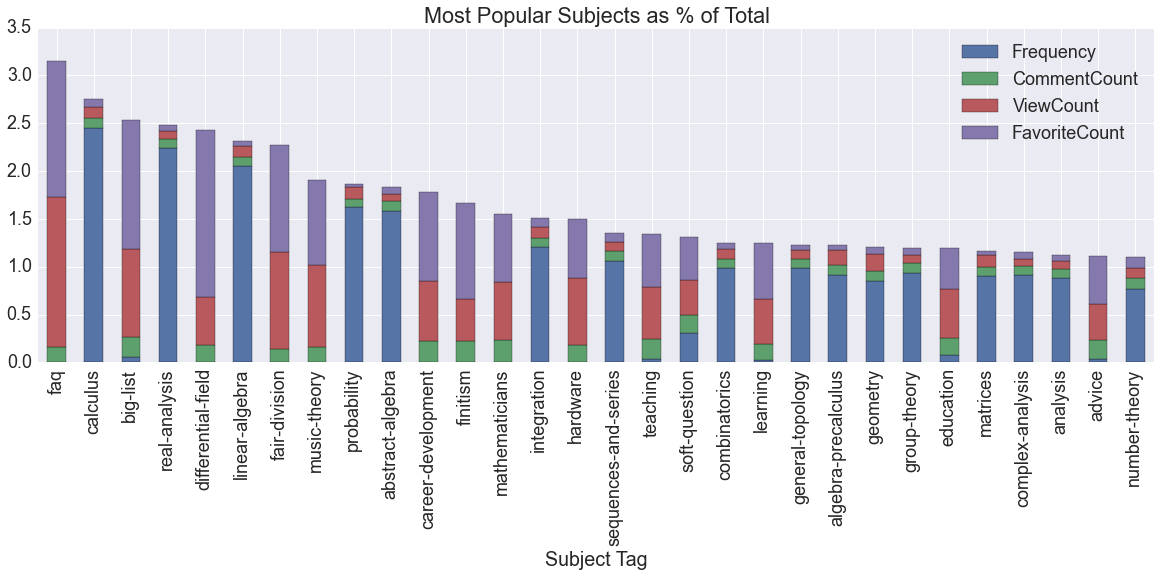

In [470]:
toptopics3 = toptopics2[['Frequency','CommentCount','ViewCount','FavoriteCount']]
sns.set(font_scale=1.8)
sns.set_context(rc={"figure.figsize": (20, 6)})   
sns.set_palette("deep", desat=.8)
ax = toptopics3[1:31].plot(kind='bar',stacked=True,title='Most Popular Subjects as % of Total',rot=90)
ax.set_xlabel("Subject Tag")

In [477]:
postdata.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'Body', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate', u'CreationDate_x', u'FavoriteCount', u'Id_x', u'LastActivityDate', u'LastEditDate', u'LastEditorDisplayName', u'LastEditorUserId', u'OwnerDisplayName', u'OwnerUserId', u'ParentId', u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'AboutMe', u'AccountId', u'Age', u'CreationDate_y', u'DisplayName', u'DownVotes', u'Id_y', u'LastAccessDate', u'Location', u'ProfileImageUrl', u'Reputation', u'UpVotes', u'Views', u'WebsiteUrl', u'Longevity', u'LongevitySeconds', u'BodyLength', u'HighSchoolSubject'], dtype='object')

## Begin ML test

In [486]:
# Let's import some stuff to play with
import csv
import pandas as pd
import numpy as np
from numpy import where
import pickle
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, datasets, metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

import pylab as pl
import pylab
import seaborn as sns

In [484]:
postdataml = postdata[postdata.HighSchoolSubject != 0.5]
X = postdataml[['AnswerCount','BodyLength','CommentCount','FavoriteCount','ViewCount','LongevitySeconds','BodyLength']]
y = postdataml.HighSchoolSubject

In [483]:
print len(postdata)
print len(postdataml)

1002935
197709


In [487]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [492]:
models = [LogisticRegression(), SVC(probability = True), GaussianNB(), DecisionTreeClassifier(max_depth = 4), RandomForestClassifier(), KNeighborsClassifier(n_neighbors = 9)]

def roc_param(estimator, train_X, test_X):
    model = estimator
    model.fit(train_X, y_train)
    if estimator == SVC():
        test_pred = model.predict(test_X)
        fpr, tpr, _ = metrics.roc_curve(y_test, test_pred)
    else:
        test_pred = model.predict_proba(test_X)
        fpr, tpr, _ = metrics.roc_curve(y_test, test_pred[:,1])
    roc_params = [fpr, tpr]
    return roc_params

In [ ]:
log_scaled_roc = roc_param(models[0], X_train_std, X_test_std)
svc_scaled_roc = roc_param(models[1], X_train_std, X_test_std)
gnb_scaled_roc = roc_param(models[2], X_train_std, X_test_std)
dtree_scaled_roc = roc_param(models[3], X_train_std, X_test_std)
rf_scaled_roc = roc_param(models[4], X_train_std, X_test_std)
knn_scaled_roc = roc_param(models[5], X_train_std, X_test_std)

In [ ]:
plt.title("ROC curves for models using scaled predictors")
plt.plot(log_scaled_roc[0], log_scaled_roc[1], "b", linewidth = 2, label = "Logistic Regression")
plt.plot(svc_scaled_roc[0], svc_scaled_roc[1], "k", linewidth = 2, label = "Support Vector Machines")
plt.plot(gnb_scaled_roc[0], gnb_scaled_roc[1], "g", linewidth = 2, label = "GaussianNB")
plt.plot(dtree_scaled_roc[0], dtree_scaled_roc[1], "r", linewidth = 2, label = "Decision Tree")
plt.plot(rf_scaled_roc[0], rf_scaled_roc[1], "c", linewidth = 2, label = "Random Forest")
plt.plot(knn_scaled_roc[0], knn_scaled_roc[1], "y", linewidth = 2, label = "K Neighbors (9)")
plt.legend(loc = 4, prop={'size':24})
plt.show()

In [ ]:
scores = [accuracy_score, precision_score, recall_score, f1_score]

def get_metrics(X_train, X_test):
    
    # create empty lists
    LogisticReg = []
    SVMC = []
    GaussNB = []
    DecisionTree = []
    RandomForest = []
    kNN9 = []
    
    # list of lists
    lists = [LogisticReg, SVMC, GaussNB, DecisionTree, RandomForest, kNN9]
    
    # populate lists with scores of each scoring method
    for i, model in enumerate(models):
        for score in scores:
            est = model
            est.fit(X_train, y_train)
            pred = est.predict(X_test)
            lists[i].append(score(y_test, pred))
        
    # create a dataframe which aggregates the lists
    scores_df = pd.DataFrame(data = [LogisticReg, SVMC, GaussNB, DecisionTree, RandomForest, kNN9])
    scores_df.index = ["LogisticReg", "SVMC", "GaussNB", "DecisionTree", "RandomForest", "kNN9"]
    scores_df.columns = ["Accuracy", "Precision", "Recall", "F1"]
    return scores_df

In [ ]:
get_metrics(X_train_std, X_test_std)

## Document Clustering

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [ ]:
postdatadc = postdata[['Id_x','Body','Title','Tags']]
postdatadc.head()

To Do: 
1. Exploratory viz stuff
2. Classify education level
    - I am 99% sure that it is a high school level question (ex: geometry)
    - I am 100% sure that these are not high school level (ex: abstract algebra)
3. Clustering on text to get more high school texts within untagged posts
4. Data viz on high school / not high school
5. Topic modeling for more granularity within tags
6. what topics are students struggling with in their subjects which might make them give up
7. Most complex, hotly debated, or fundamental

### Presentation
- High school is like a user experience. How can we identify when high school students as users  of the education system experience pain points which may inhibit their progress. 
- Everyone has pain points with the process. Some students are able to surmount those obstacles, while other may need targeted help to get the most out of the available system.
- Often when speaking about mathematics you hear people say that they aren't math people, or aren't good at math and you find out that they hit a wall. It's like anything in life which is difficult. You hit a wall and you either push through it or you don't. 
- present it as a paradigm which is a process which can be improved upon. there are answers that we can deivgn about how to teach people that are better or worse than others. Testing to figure out where are the pain points and where are students falling behind, particularly in math/science. 
- These are users /consumers of education. 
- I'm builing a tool which can target at what point students are exiting the process. 